In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

VER = 172
POSTFIX = ''

USE = 'orders'

CT=100

In [2]:
import pandas as pd, cudf, numpy as np, gc
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt

In [3]:
users = pd.read_parquet(f'../../data/train_with_features/train_v{VER}.pqt')
print( users.shape )
users.head()

(13465600, 202)


,user,item,pos,wgt,orders,score_1,score_3,score_4,score_5,score_6,score_7,score_10,score_11,score_12,score_13,score_30,score_14,score_15,score_16,score_17,score_18,score_19,score_20,score_21,score_22,score_23,score_24,score_25,score_26,buy_ratio_5,count_item_5,count_user_5,repeat_5,buy_ratio_std_5,item_day_std_5,user_day_std_5,buy_ratio_0_6,buy_ratio_1_6,buy_ratio_2_6,buy_ratio_3_6,buy_ratio_4_6,buy_ratio_5_6,buy_ratio_6_6,count_item_0_6,count_item_1_6,count_item_2_6,count_item_3_6,count_item_4_6,count_item_5_6,count_item_6_6,count_user_0_6,count_user_1_6,count_user_2_6,count_user_3_6,count_user_4_6,count_user_5_6,count_user_6_6,item_day_std_6,user_day_std_6,buy_ratio,count_item,count_user,hour_mean,day_mean,repeat,buy_ratio_std,hour_std,day_std,buy_ratio3,count_item3,count_user3,hour_mean3,day_mean3,repeat3,buy_ratio_std3,hour_std3,day_std3,prev3,next3,orders3,carts3,order_repeat3,cart_repeat3,buy_ratio2,count_item2,unique_item2,hour_mean2,day_mean2,repeat2,buy_ratio_std2,hour_std2,day_std2,ts_max7,ts_min7,ts_diff7,z1,z2,z3,z4,z5,z6,buy_ratio7,count_item7,count_user7,hour_mean7,day_mean7,repeat7,buy_ratio_std7,hour_std7,day_std7,prev7,next7,orders7,carts7,order_repeat7,cart_repeat7,buy_ratio8,count_item8,count_user8,hour_mean8,day_mean8,repeat8,buy_ratio_std8,hour_std8,day_std8,prev8,next8,orders8,carts8,order_repeat8,cart_repeat8,buy_ratio9,count_item9,count_user9,hour_mean9,day_mean9,repeat9,buy_ratio_std9,hour_std9,day_std9,prev9,next9,orders9,carts9,order_repeat9,cart_repeat9,buy_ratio10,count_item10,unique_item10,hour_mean10,day_mean10,repeat10,buy_ratio_std10,hour_std10,day_std10,z10,z11,buy_ratio11,count_item11,count_user11,hour_mean11,day_mean11,repeat11,buy_ratio_std11,hour_std11,day_std11,buy_ratio12,count_item12,count_user12,hour_mean12,day_mean12,repeat12,buy_ratio_std12,hour_std12,day_std12,buy_ratio13,count_item13,count_user13,hour_mean13,day_mean13,repeat13,buy_ratio_std13,hour_std13,day_std13,buy_ratio14,count_item14,unique_item14,hour_mean14,day_mean14,repeat14,buy_ratio_std14,hour_std14,day_std14,buy_ratio15,count_item15,unique_item15,hour_mean15,day_mean15,repeat15,buy_ratio_std15,hour_std15,day_std15
0,11098528,11830,0,-1.000000,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.514214,-1.0,0.671773,-1.0,-1.000,1.414214,1.514214,1.414214,1.414214,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.188454,14481.0,8606.0,1.682663,0.474975,643.345764,643.345764,0.132450,0.173267,0.148649,0.135000,0.115385,0.097744,0.061404,151.0,202.0,222.0,200.0,208.0,133.0,114.0,112.0,130.0,145.0,142.0,156.0,99.0,80.0,42.248135,42.248135,0.175659,32546.0,18362.0,49847.566406,308206.03125,1.772465,0.459607,17870.607422,193386.031250,0.129268,1230.0,849.0,50060.824219,313896.90625,1.448763,0.372407,17396.035156,186814.156250,369.0,372.0,16.0,127.0,1.066667,1.067227,0.0,1.0,1.0,79200.0,338400.0,1.0,-1.0,-1.0,-1.0,0,0,0,1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,0.163253,8153.0,5035.0,48766.132812,309523.93750,1.619265,0.450127,17233.292969,181986.593750,2183.0,2087.0,269.0,793.0,3.086957,2.235294,0.154491,16700.0,10043.0,64008.941406,322344.93750,1.662850,0.430123,10567.528320,193000.531250,4227.0,3740.0,454.0,1672.0,2.224138,2.139628,0.197968,15846.0,9400.0,34922.984375,293305.12500,1.685745,0.487779,10204.664062,192677.828125,4013.0,3537.0,627.0,1883.0,1.958491,1.965084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.233175,4636.0,2785.0,47927.398438,308860.62500,1.664632,0.422898,18213.400391,198956.890625,1.111888,143.0,122.0,48456.414062,334845.21875,1.172131,0.316337,15841.716797,195765.437500,1.111888,143.0,122.0,48456.414062,334845.21875,1.172131,0.316337,15841.716797,195765.4375,0.0,1.0,1.0,79200.0,338400.0,1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11098528,1732105,1,36.650002,0,2.0,2.0,-3.0,2.0,3.5,4.0,0.850000,17.5,1.500000,8.0,10.995,-3.000000,0.050000,-3.000000,0.800000,4.0,2.0,-3.0,2.0,4.0,2.0,2.0,3.5,1.0,0.289084,4324.0,2518.0,1.717236,0.558128,190.647705,190.647705,0.395349,0.433333,0.160714,0.200000,0.194444,0.166667,0.031250,4

In [4]:
users.user.nunique()

134656

In [5]:
users2 = cudf.DataFrame( users[['user','item']] ).reset_index()
users2.head()

,index,user,item
0,0,11098528,11830
1,1,11098528,1732105
2,2,11098528,588923
3,3,11098528,1157882
4,4,11098528,884502


In [6]:
df = cudf.read_parquet('../../data/train_data/test.parquet')
#MN = df.ts.min()

df = df.sort_values(['session','ts'], ascending=[True,False]).reset_index(drop=True)
df['x'] = df.groupby('session').cumcount()

for k in range(5):
    nm = f'last_{k}'
    tmp = df.loc[df.x==k]
    tmp = tmp[['session','aid']]

    tmp.columns = ['user',nm]

    users2 = users2.merge(tmp,on='user',how='left')
    users2[nm] = users2[nm].fillna(-1)

In [7]:
#users2.sample(10)

In [8]:
df = df.sort_values(['session','ts'], ascending=[True,True]).reset_index(drop=True)
df['x'] = df.groupby('session').cumcount()

for k in range(5):
    nm = f'first_{k}'
    tmp = df.loc[df.x==k]
    tmp = tmp[['session','aid']]

    tmp.columns = ['user',nm]

    users2 = users2.merge(tmp,on='user',how='left')
    users2[nm] = users2[nm].fillna(-1)

In [9]:
df = df.loc[df['type']>0]
df = df.sort_values(['session','ts'], ascending=[True,False]).reset_index(drop=True)
df['x'] = df.groupby('session').cumcount()

for k in range(5):
    nm = f'buy_{k}'
    tmp = df.loc[df.x==k]
    tmp = tmp[['session','aid']]

    tmp.columns = ['user',nm]

    users2 = users2.merge(tmp,on='user',how='left')
    users2[nm] = users2[nm].fillna(-1)

In [10]:
users2.sample(10)

,index,user,item,last_0,last_1,last_2,last_3,last_4,first_0,first_1,first_2,first_3,first_4,buy_0,buy_1,buy_2,buy_3,buy_4
2740331,2774219,11454313,1570905,163093,-1,-1,-1,-1,163093,-1,-1,-1,-1,-1,-1,-1,-1,-1
10848751,10850943,12564717,775680,1719462,1552115,-1,-1,-1,1552115,1719462,-1,-1,-1,-1,-1,-1,-1,-1
10880870,10882774,12569738,1831196,882800,815195,1111376,815195,1275942,1048306,885051,815195,1275942,815195,-1,-1,-1,-1,-1
5056989,5098125,11774328,1548742,395918,336884,-1,-1,-1,336884,395918,-1,-1,-1,-1,-1,-1,-1,-1
915033,967513,11209091,1608777,942224,1149243,-1,-1,-1,1149243,942224,-1,-1,-1,-1,-1,-1,-1,-1
9344566,9293270,12365975,890731,582412,1501983,1501983,546727,546727,872564,1040894,1230401,863362,1557845,1501983,546727,920459,1040894,24642
2849528,2818584,11460353,1658239,1259136,1259136,1637355,422357,1259136,422357,422357,1259136,1259136,1259136,1259136,1637355,1259136,773888,1404465
11932228,11949732,12705371,604249,1437688,1437688,1437688,-1,-1,1437688,1437688,1437688,-1,-1,1437688,-1,-1,-1,-1
7668765,7671149,12141662,598313,1014094,1505552,481532,1505552,840728,840728,1505552,840728,1505552,840728,840728,-1,-1,-1,-1
7762569,7742089,12159465,1345769,640389,399214,64664,1571602,399214,1059174,1059174,1128777,1021718,164613,164613,1571602,1571602,1571602,164613


In [11]:
import numpy as np, cupy as cp

def normalize(v):
    if len(v.shape)>1:
        return v / np.sqrt(np.sum(v**2, 1 , keepdims=True))
    else:
        return v / np.sqrt(np.sum(v**2))
    
# WE NEED GIBA EMBEDDINGS HERE
# https://github.com/TheoViel/kaggle_otto_rs/blob/master/notebooks/4-Seq2Seq_Giba.ipynb
try:
    emb = cp.asarray(normalize(np.load('../../data/item_user_features/embbedings_fm10.npy')))
except:
    emb = cp.asarray(normalize(np.load('../../data/item_user_features/item_embed_32.npy')))
emb.shape

(1855603, 256)

In [12]:
def build_dist(a0, a1, BS = 32*256*256):
    global emb
    res = cp.zeros(len(a0))
    for batch in np.arange(0, len(a0), BS):
        emb0 = emb[cp.clip(a0[batch:batch+BS], 0, None)]
        emb1 = emb[cp.clip(a1[batch:batch+BS], 0, None)]
        res[batch:batch+BS] = cp.sum((emb0 * emb1), 1)
    del emb0, emb1
    
    return cp.asnumpy(res)

In [13]:
SHOW_HIST = True

### 0
missing = 0


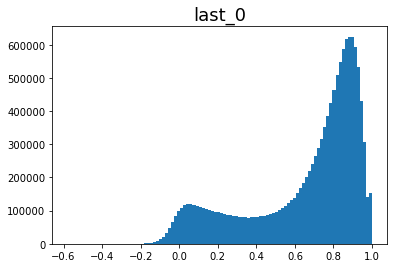

### 1
missing = 1584500


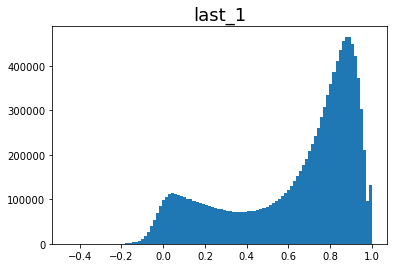

### 2
missing = 3298600


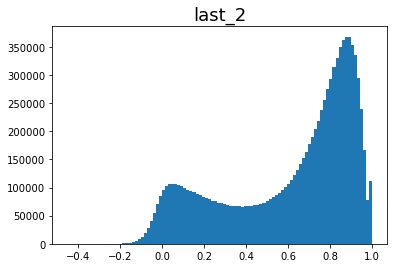

### 3
missing = 4860200


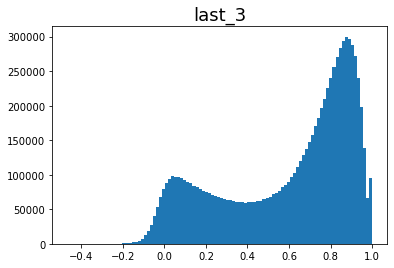

### 4
missing = 6056800


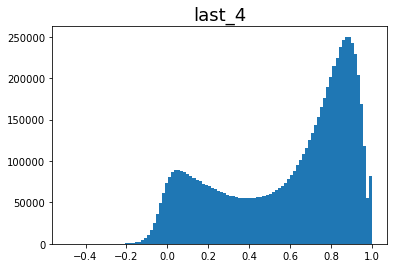

In [14]:
for k in range(5):
    print('###',k)
    nm = f'last_{k}'
    
    mask = users2[nm] != -1
    print('missing =', len(users2) - mask.sum() )
    
    x = build_dist(users2.item.values, users2[nm].values)
    
    users2.loc[mask,nm] = x[mask.to_numpy()]
    
    if SHOW_HIST:
        plt.hist(x[mask.to_numpy()], bins=100)
        plt.title(nm,size=18)
        plt.show()

### 0
missing = 0


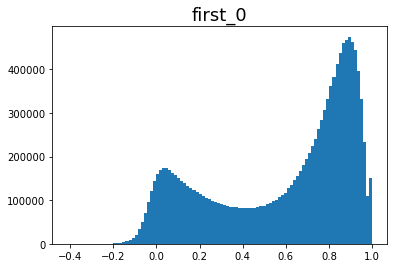

### 1
missing = 1584500


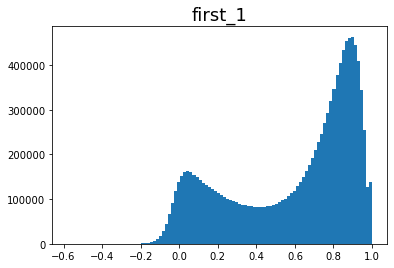

### 2
missing = 3298600


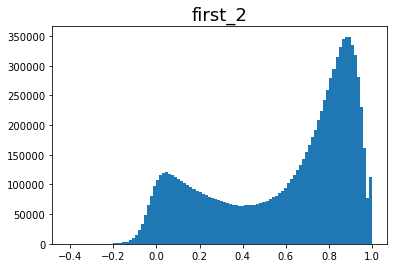

### 3
missing = 4860200


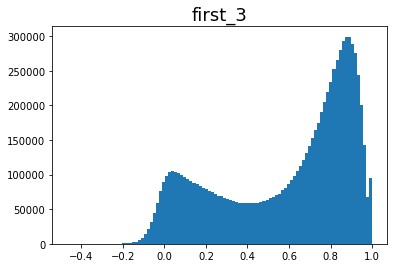

### 4
missing = 6056800


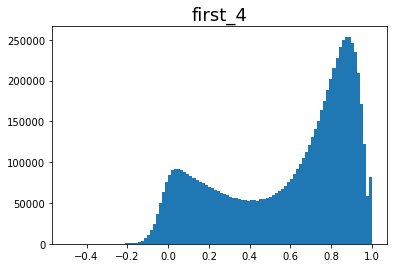

In [15]:
for k in range(5):
    print('###',k)
    nm = f'first_{k}'
    
    mask = users2[nm] != -1
    print('missing =', len(users2) - mask.sum() )
    
    x = build_dist(users2.item.values, users2[nm].values)
    
    users2.loc[mask,nm] = x[mask.to_numpy()]
    
    if SHOW_HIST:
        plt.hist(x[mask.to_numpy()], bins=100)
        plt.title(nm,size=18)
        plt.show()

### 0
missing = 4458200


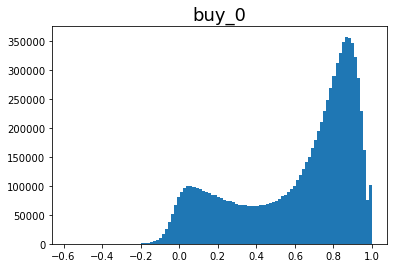

### 1
missing = 8218800


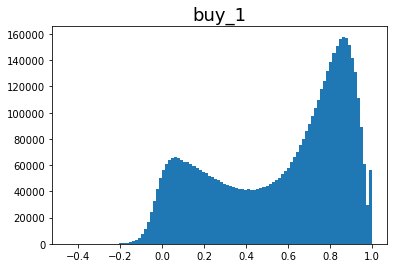

### 2
missing = 10010900


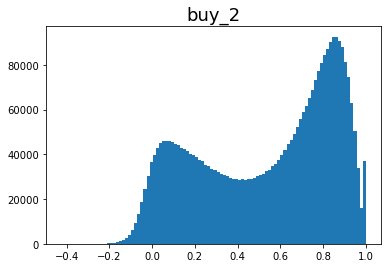

### 3
missing = 11072600


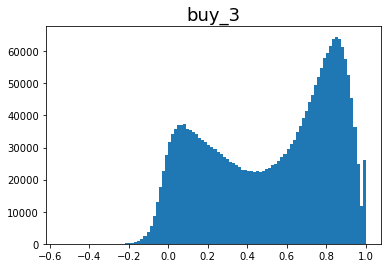

### 4
missing = 11718200


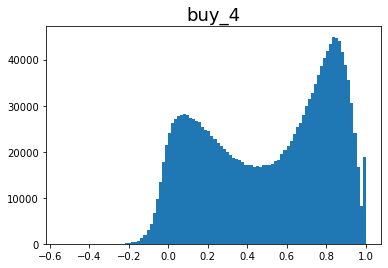

In [16]:
for k in range(5):
    print('###',k)
    nm = f'buy_{k}'
    
    mask = users2[nm] != -1
    print('missing =', len(users2) - mask.sum() )
    
    x = build_dist(users2.item.values, users2[nm].values)
    
    users2.loc[mask,nm] = x[mask.to_numpy()]
    
    if SHOW_HIST:
        plt.hist(x[mask.to_numpy()], bins=100)
        plt.title(nm,size=18)
        plt.show()

In [17]:
users2.head()

,index,user,item,last_0,last_1,last_2,last_3,last_4,first_0,first_1,first_2,first_3,first_4,buy_0,buy_1,buy_2,buy_3,buy_4
0,11776,11099167,217041,0.653004,0.782671,0.763032,0.809753,0.765930,0.121973,0.121973,0.033500,0.033500,0.071630,-1.0,-1.0,-1.0,-1.0,-1.0
1,11777,11099167,1774066,-0.051160,-0.028267,0.008258,0.029759,0.021047,0.888228,0.888228,0.772020,0.772020,0.853922,-1.0,-1.0,-1.0,-1.0,-1.0
2,11778,11099167,349798,0.780690,0.903321,0.889336,0.873344,0.929854,0.135516,0.135516,0.072634,0.072634,0.110250,-1.0,-1.0,-1.0,-1.0,-1.0
3,11779,11099167,612506,0.302408,0.300741,0.291864,0.284257,0.434106,0.038693,0.038693,0.040292,0.040292,0.009919,-1.0,-1.0,-1.0,-1.0,-1.0
4,11780,11099167,1457663,0.229935,0.258146,0.279888,0.194785,0.391786,0.031191,0.031191,0.012562,0.012562,0.034668,-1.0,-1.0,-1.0,-1.0,-1.0


In [18]:
cols1 = [f'last_{x}' for x in range(5)]
cols2 = [f'first_{x}' for x in range(5)]
cols3 = [f'buy_{x}' for x in range(5)]
cols = cols1 + cols2 + cols3
len( cols )

15

In [19]:
for c in cols:
    users2.loc[users2[c]==-1,c] = np.nan

In [20]:
for k,c in enumerate( [cols1,cols2,cols3,cols] ):
    users2[f'e_mean_{k}'] = users2[cols].mean(axis=1)
    users2[f'e_std_{k}'] = users2[cols].std(axis=1)

In [21]:
users2 = users2.fillna(-1)

In [22]:
users2 = users2.sort_values('index').reset_index(drop=True).drop('index',axis=1)

In [23]:
users2.head()

,user,item,last_0,last_1,last_2,last_3,last_4,first_0,first_1,first_2,first_3,first_4,buy_0,buy_1,buy_2,buy_3,buy_4,e_mean_0,e_std_0,e_mean_1,e_std_1,e_mean_2,e_std_2,e_mean_3,e_std_3
0,11098528,11830,1.000000,-1.0,-1.0,-1.0,-1.0,1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.0
1,11098528,1732105,0.952010,-1.0,-1.0,-1.0,-1.0,0.952010,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.952010,0.0,0.952010,0.0,0.952010,0.0,0.952010,0.0
2,11098528,588923,0.939679,-1.0,-1.0,-1.0,-1.0,0.939679,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.939679,0.0,0.939679,0.0,0.939679,0.0,0.939679,0.0
3,11098528,1157882,0.844975,-1.0,-1.0,-1.0,-1.0,0.844975,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.844975,0.0,0.844975,0.0,0.844975,0.0,0.844975,0.0
4,11098528,884502,0.872546,-1.0,-1.0,-1.0,-1.0,0.872546,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.872546,0.0,0.872546,0.0,0.872546,0.0,0.872546,0.0


# EDA Columns

In [24]:
for i,c in enumerate(users2.columns):
    if not c in ['user','item']:
        users2[c] = users2[c].astype('float32')
    print(c,users2[c].dtype)

user int32
item int32
last_0 float32
last_1 float32
last_2 float32
last_3 float32
last_4 float32
first_0 float32
first_1 float32
first_2 float32
first_3 float32
first_4 float32
buy_0 float32
buy_1 float32
buy_2 float32
buy_3 float32
buy_4 float32
e_mean_0 float32
e_std_0 float32
e_mean_1 float32
e_std_1 float32
e_mean_2 float32
e_std_2 float32
e_mean_3 float32
e_std_3 float32


In [25]:
for c in users2.columns[:2]:
    print(c,', ',end='')

user , item , 

In [26]:
for c in users2.columns[2:]:
    print(c,', ',end='')
    users[c] = users2[c].to_numpy()
del users2
gc.collect()

last_0 , last_1 , last_2 , last_3 , last_4 , first_0 , first_1 , first_2 , first_3 , first_4 , buy_0 , buy_1 , buy_2 , buy_3 , buy_4 , e_mean_0 , e_std_0 , e_mean_1 , e_std_1 , e_mean_2 , e_std_2 , e_mean_3 , e_std_3 , 

62398

In [27]:
for c in users.columns:
    t = str(users[c].dtype)
    if (t=='int64'): 
        users[c] = users[c].astype('int32')
        print('convert',c,'to int32')
    if (t=='float64')|(t=='Int32')|(t=='Float32'):
        users[c] = users[c].astype('float32')
        print('convert',c,'to float32')

In [28]:
print( users.shape )
users.head()

(13465600, 225)


,user,item,pos,wgt,orders,score_1,score_3,score_4,score_5,score_6,score_7,score_10,score_11,score_12,score_13,score_30,score_14,score_15,score_16,score_17,score_18,score_19,score_20,score_21,score_22,score_23,score_24,score_25,score_26,buy_ratio_5,count_item_5,count_user_5,repeat_5,buy_ratio_std_5,item_day_std_5,user_day_std_5,buy_ratio_0_6,buy_ratio_1_6,buy_ratio_2_6,buy_ratio_3_6,buy_ratio_4_6,buy_ratio_5_6,buy_ratio_6_6,count_item_0_6,count_item_1_6,count_item_2_6,count_item_3_6,count_item_4_6,count_item_5_6,count_item_6_6,count_user_0_6,count_user_1_6,count_user_2_6,count_user_3_6,count_user_4_6,count_user_5_6,count_user_6_6,item_day_std_6,user_day_std_6,buy_ratio,count_item,count_user,hour_mean,day_mean,repeat,buy_ratio_std,hour_std,day_std,buy_ratio3,count_item3,count_user3,hour_mean3,day_mean3,repeat3,buy_ratio_std3,hour_std3,day_std3,prev3,next3,orders3,carts3,order_repeat3,cart_repeat3,buy_ratio2,count_item2,unique_item2,hour_mean2,day_mean2,repeat2,buy_ratio_std2,hour_std2,day_std2,ts_max7,ts_min7,ts_diff7,z1,z2,z3,z4,z5,z6,buy_ratio7,count_item7,count_user7,hour_mean7,day_mean7,repeat7,buy_ratio_std7,hour_std7,day_std7,prev7,next7,orders7,carts7,order_repeat7,cart_repeat7,buy_ratio8,count_item8,count_user8,hour_mean8,day_mean8,repeat8,buy_ratio_std8,hour_std8,day_std8,prev8,next8,orders8,carts8,order_repeat8,cart_repeat8,buy_ratio9,count_item9,count_user9,hour_mean9,day_mean9,repeat9,buy_ratio_std9,hour_std9,day_std9,prev9,next9,orders9,carts9,order_repeat9,cart_repeat9,buy_ratio10,count_item10,unique_item10,hour_mean10,day_mean10,repeat10,buy_ratio_std10,hour_std10,day_std10,z10,z11,buy_ratio11,count_item11,count_user11,hour_mean11,day_mean11,repeat11,buy_ratio_std11,hour_std11,day_std11,buy_ratio12,count_item12,count_user12,hour_mean12,day_mean12,repeat12,buy_ratio_std12,hour_std12,day_std12,buy_ratio13,count_item13,count_user13,hour_mean13,day_mean13,repeat13,buy_ratio_std13,hour_std13,day_std13,buy_ratio14,count_item14,unique_item14,hour_mean14,day_mean14,repeat14,buy_ratio_std14,hour_std14,day_std14,buy_ratio15,count_item15,unique_item15,hour_mean15,day_mean15,repeat15,buy_ratio_std15,hour_std15,day_std15,last_0,last_1,last_2,last_3,last_4,first_0,first_1,first_2,first_3,first_4,buy_0,buy_1,buy_2,buy_3,buy_4,e_mean_0,e_std_0,e_mean_1,e_std_1,e_mean_2,e_std_2,e_mean_3,e_std_3
0,11098528,11830,0,-1.000000,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.514214,-1.0,0.671773,-1.0,-1.000,1.414214,1.514214,1.414214,1.414214,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.188454,14481.0,8606.0,1.682663,0.474975,643.345764,643.345764,0.132450,0.173267,0.148649,0.135000,0.115385,0.097744,0.061404,151.0,202.0,222.0,200.0,208.0,133.0,114.0,112.0,130.0,145.0,142.0,156.0,99.0,80.0,42.248135,42.248135,0.175659,32546.0,18362.0,49847.566406,308206.03125,1.772465,0.459607,17870.607422,193386.031250,0.129268,1230.0,849.0,50060.824219,313896.90625,1.448763,0.372407,17396.035156,186814.156250,369.0,372.0,16.0,127.0,1.066667,1.067227,0.0,1.0,1.0,79200.0,338400.0,1.0,-1.0,-1.0,-1.0,0,0,0,1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,0.163253,8153.0,5035.0,48766.132812,309523.93750,1.619265,0.450127,17233.292969,181986.593750,2183.0,2087.0,269.0,793.0,3.086957,2.235294,0.154491,16700.0,10043.0,64008.941406,322344.93750,1.662850,0.430123,10567.528320,193000.531250,4227.0,3740.0,454.0,1672.0,2.224138,2.139628,0.197968,15846.0,9400.0,34922.984375,293305.12500,1.685745,0.487779,10204.664062,192677.828125,4013.0,3537.0,627.0,1883.0,1.958491,1.965084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.233175,4636.0,2785.0,47927.398438,308860.62500,1.664632,0.422898,18213.400391,198956.890625,1.111888,143.0,122.0,48456.414062,334845.21875,1.172131,0.316337,15841.716797,195765.437500,1.111888,143.0,122.0,48456.414062,334845.21875,1.172131,0.316337,15841.716797,195765.4375,0.0,1.0,1.0,79200.0,338400.0,1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-1.0,-1.0,-1.0,-1.0,1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.000000,0.0,1.000000,0.0,1.000000,0.0

In [29]:
%%time
users.to_parquet(f'../../data/train_with_features/train_v{VER}.pqt',index=False)

CPU times: user 1min 25s, sys: 3.08 s, total: 1min 28s
Wall time: 1min 5s
